In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# print("Path to dataset files:", path)

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:20<00:00, 187MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s]


In [7]:
import zipfile
with zipfile.ZipFile('chest-xray-pneumonia.zip','r') as zip_ref:
  zip_ref.extractall()

In [8]:
# import all the Libraries


In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report


In [12]:
train_dir = 'chest_xray/train'
test_dir ='chest_xray/test'
val_dir ='chest_xray/val'

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.15,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    #  brightness_range=[0.7, 1.3]
)


Found 5216 images belonging to 2 classes.


In [15]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle = False
)

Found 624 images belonging to 2 classes.


In [17]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [18]:
val_datagenerator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
    )

Found 16 images belonging to 2 classes.


In [19]:
model = Sequential()

In [20]:
conv_base = tensorflow.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
conv_base.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [23]:
model = Sequential()
model.add(conv_base)
model.add(Dense(256,activation='relu',input_shape=(225,225,3), kernel_regularizer= l2(0.000001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu' , kernel_regularizer= l2(0.000001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(32,activation='relu' , kernel_regularizer= l2(0.000001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
adam = Adam(learning_rate=0.001)

In [26]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [27]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

In [28]:
history = model.fit(train_generator,epochs=10,validation_data=val_datagenerator,callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 332s 843ms/step - acc: 0.8377 - loss: 0.3816 - val_acc: 0.8125 - val_loss: 1.4422
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 906ms/step - acc: 0.9500 - loss: 0.1327 - val_acc: 0.6875 - val_loss: 2.0922
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 774ms/step - acc: 0.9541 - loss: 0.1230 - val_acc: 0.7500 - val_loss: 0.9632
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 752ms/step - acc: 0.9620 - loss: 0.0969 - val_acc: 0.8750 - val_loss: 0.2378
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 738ms/step - acc: 0.9607 - loss: 0.1027 - val_acc: 0.7500 - val_loss: 0.4319
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 741ms/step - acc: 0.9693 - loss: 0.0828 - val_acc: 0.8750 - val_loss: 0.3852
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 733ms/step - acc: 0.9702 - loss: 0.0803 - val_acc: 0.5625 - val_loss: 1.5434
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 735ms/step - acc: 0.9683 - loss: 0.0837 - val_acc: 0.6250 - val_loss: 1.4247
Epoch 9/10
163/163 ━━━━━

In [30]:
model.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 525ms/step - acc: 0.8706 - loss: 0.3676


[0.27101588249206543, 0.9054487347602844]

In [31]:
y_pred_proba = model.predict(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step


In [32]:
y_pred =np.where(y_pred_proba>0.5,1,0)

In [33]:
class_indices ={1:"Pneumonia", 0:"Normal"}

In [34]:
y_pred_final = class_indices[y_pred[0][0]]

In [35]:
y_pred_final

'Normal'

In [36]:
import cv2

In [56]:
from sklearn.metrics import classification_report

y_true = test_generator.classes

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       234
           1       0.90      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [58]:


from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score
import seaborn as sb

In [43]:
print("COnfusion_matrix \n")
confusion_matrix(y_true,y_pred)

COnfusion_matrix 



array([[190,  44],
       [ 12, 378]])

<Axes: >

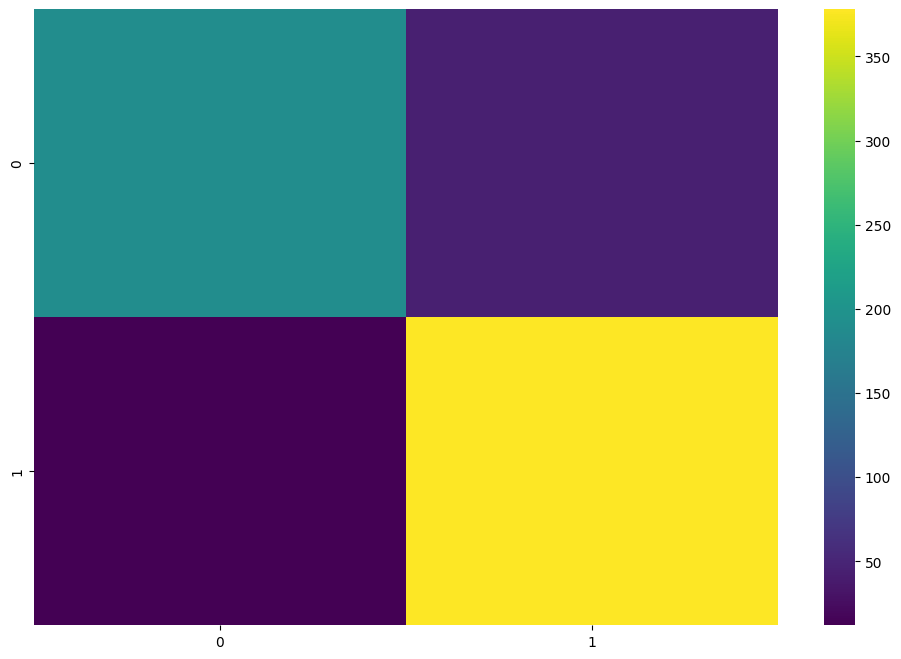

In [44]:
plt.figure(figsize=(12,8))
sb.heatmap(confusion_matrix(y_true,y_pred),cmap='viridis')

In [45]:
# ----------------------------
from tensorflow.keras.preprocessing import image

In [46]:
def predict_image(img_path):
  img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
  img_array = image.img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)

  prediction = model.predict(img_array)[0][0]
  if prediction > 0.5:
    return "PNEUMONIA"
  else:
    return "NORMAL"

In [63]:
precision_score(y_pred,y_true) ## Which is Good

0.9692307692307692

In [61]:
accuracy_score(y_pred,y_true)

0.9102564102564102

In [49]:
## Example
IMG_SIZE = 224
result = predict_image('/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [53]:
result ## predicted Correctly

'NORMAL'

In [51]:
result2 = predict_image('/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [54]:
print(result2) # predicted Correctly

PNEUMONIA


In [64]:
## Another One

In [65]:
result3 = predict_image('/content/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [67]:
result3 ## predicted Correctly

'PNEUMONIA'